# ENRON Email Dataset: PageRank, KMeans, Spectral Graph 


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import email
import re
import networkx as nx
import scipy as sp

from random import sample # for kmeans

Use the Enron emails dataset from lecture 15.

In [ ]:
#read in emails from dataframe, view df 
#emails_df = pd.read_csv('emails_10k.csv')
#emails_df.head()

url = 'https://gist.githubusercontent.com/aulichney/be4118fc699673d99b2145f08d5f49e0/raw/a31bff5f0d86242ba548e40bd4cd4c824284ffbb/emails_10k.csv'
emails_df = pd.read_csv(url)

In [ ]:
# create list of messages
messages = list(map(email.message_from_string, emails_df['message']))

#store keys
keys = messages[0].keys()

#create col for each key
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]

#parse messages    
emails_df['content'] = [msg.get_payload() for msg in messages]

In [ ]:
#view columns we have
keys

['Message-ID',
 'Date',
 'From',
 'To',
 'Subject',
 'Mime-Version',
 'Content-Type',
 'Content-Transfer-Encoding',
 'X-From',
 'X-To',
 'X-cc',
 'X-bcc',
 'X-Folder',
 'X-Origin',
 'X-FileName']

In [ ]:
#store cols of interest in df 
df = emails_df[['From', 'To','X-cc', 'X-bcc']]

In [ ]:
df['To'][63]

'thomas.martin@enron.com, mike.grigsby@enron.com, keith.holst@enron.com, \n\tjay.reitmeyer@enron.com, frank.ermis@enron.com'

In [ ]:
def getaddresses(cc):
    #check to make sure the input is not none. can't split nonetype
    if cc:
        #get rid of quotes, <, >, /, \n, and \t. I noticed that some group emails have / in them so I decided to not filter for that characted on its own
        keep = [item.strip(' ').replace('"', '').replace('<', '').replace('>','').replace('\\','').replace('\n', '').replace('\t','') for item in cc.split(',')]
        return keep
    else:
        return None

In [ ]:
#the following lines generate a csv where the to field before and after processing are compared
# to make sure I am processing and cleaning adequately. it indicates that i've removed all that is needed 
#df['Test'] = df['To'].apply(getaddresses)
#df[['Test', 'To']].to_csv('emailoutput.csv')

In [ ]:
#function that counts the number of @ symbol in a string, returns none if input is none
def countat(string):
    if string:
        return int(string.count('@'))
    else:
        return None

In [ ]:
#funtion that counts number of @ symbol in array 
def countatlist(row):
    if row:
        return '-'.join(row).count('@')
    else:
        return None

In [ ]:
#also check that number of email addresses is the same in each by counting '@'s
#uncomment if you want to confirm the cleaning.

# df['ToCount'] = df['To'].apply(countat)
# df['OutputCount'] = df['Test'].apply(countatlist)

# df['Diff'] = df['ToCount'] - df['OutputCount']

# df[['Diff','OutputCount', 'ToCount']].to_csv('countoutput.csv')

# #check to make sure all are the same-- they are! we know we have the same numbber of emails before and after cleaning.
# df[df['Diff']>0]

In [ ]:
#check what an empty string returns, check what none returns
getaddresses('')
getaddresses(None)

In [ ]:
#check a list to make sure this works on multiple emails
getaddresses(df['To'][63])

['thomas.martin@enron.com',
 'mike.grigsby@enron.com',
 'keith.holst@enron.com',
 'jay.reitmeyer@enron.com',
 'frank.ermis@enron.com']

In [ ]:
#check that to and from have same number entries
len(emails_df['To'].values) == len(emails_df['From'].values)

True

In [ ]:
#create list of tuples of sender and recipients of each email 
email_list = list(zip(emails_df['From'], emails_df['To']))

In [ ]:
#create set of edges to later form a graph where both from and to are not none
#edge is formed for each email that is sent from sender to each unique recipient

Edges = []

for f, t in email_list:
    #check that both are not none
    if f and t:
        #apply function to parse emails
        all_recipients = getaddresses(t)
        #create edge
        for r in all_recipients:
            Edges.append((f, r))

In [ ]:
#create directed graph from the edge node set of email addresses and emails sent
#each sender or recipient is a node and each edge is an email again 

#create direected graph
G = nx.DiGraph()

#add nodes for each email and edge betweenn them
for f, t in Edges:
    G.add_node(f)
    G.add_node(t)
    G.add_edge(f,t)

In [ ]:
#check number of nodes, this is number of unique addresses 
len(G.nodes)

3962

In [ ]:
#check number of unique edges. this is number of emails that are sent between them
len(G.edges)

7914

In [ ]:
#must do while bc removal can introduce new indeg = 0 nodes
while True:
    
    #keep track of which nodes we must remove and how many
    rmv = []
    rmv_count = 0
    
    #loop through each node, find children
    for node in G.nodes():
        child = []
        
        for c in G.successors(node):
            child += [c]
        
        #check if no children or only points to self
        if len(child) == 0 or child == [node]:
            rmv.append(node)
            rmv_count = 1
    
    #remove all no children nodes
    for n in rmv:
        G.remove_node(n)
     
    #break loop once we got them all
    if rmv_count == 0:
        break
            
    

In [ ]:
#this loop double checks that we removed everything we intended to remove. same logic as above 
for node in G.nodes():
    child = []
    for c in G.successors(node):
        child += [c]
    
    if len(child) == 0 or child == [node]:
        print('Failure!')
        

In [ ]:
#let's check how many we removed by doing this
len(G.nodes)

443

In [ ]:
len(G.edges)

1769

In [ ]:
#check that out degree of all nodes is greater than 0 
min(G.out_degree) != 0

True

In [ ]:
#curious to also check in degree
min(G.in_degree) != 0

True

In [ ]:
#first use the nx function to get a sense of what we expect here 

nx.pagerank(G, alpha=0.85)

{"'todd'.delahoussaye@enron.com": 0.001675164941639112,
 '1.10969419.-18@multexinvestornetwork.com': 0.00033860045146726867,
 '1.10969419.-2@multexinvestornetwork.com': 0.00033860045146726867,
 '1.10969419.-3@multexinvestornetwork.com': 0.00033860045146726867,
 'a..roberts@enron.com': 0.0004685803111035872,
 'a..shankman@enron.com': 0.002903936894641545,
 'adam.r.bayer@vanderbilt.edu': 0.0014614422243714531,
 'admin.enron@enron.com': 0.00033860045146726867,
 'adrianne.engler@enron.com': 0.002513386458082695,
 'ajay.jagsi@owen2002.vanderbilt.edu': 0.00033860045146726867,
 'al.pollard@newpower.com': 0.0010995520897669033,
 'alan.aronowitz@enron.com': 0.003048177725650031,
 'alan_batt@oxy.com': 0.0014614422243714531,
 'alerts-finance@yahoo-inc.com': 0.00033860045146726867,
 'alex.hernandez@enron.com': 0.0003709595565311577,
 'alyse.herasimchuk@enron.com': 0.00033860045146726867,
 'amy.cavazos@enron.com': 0.0014672979798902156,
 'amy.gambill@enron.com': 0.00033860045146726867,
 'amy.spoede

In [ ]:
#function that calculates page rank of each email address given a graph of edges and nodes
def pr(graph_in):
    #create adjacency matrix and vector of degrees, invert that vector, multiply the two togeter
    A = nx.adjacency_matrix(graph_in)
    D_vec = np.array([graph_in.out_degree(v) for v in graph_in.nodes])
    DInv = sp.sparse.diags(1/D_vec)
    W = A.T @ DInv
    
    #initialize page rank approx vector that we will return, initialize alpha
    papprox=np.zeros(len(graph_in.nodes))
    alpha = 0.85
    
    #aW = np.identity(len(graph_in.nodes))
    
    for j in range(100):
        #papprox = papprox + (1-alpha)/len(graph_in.nodes) * aW@np.ones(len(graph_in.nodes))
        papprox = (1-alpha)*np.ones(len(graph_in.nodes))/len(graph_in.nodes) + alpha*W*papprox

    
    return dict(zip(list(G.nodes), papprox))

In [ ]:
#my page ranks
pr(G)

{"'todd'.delahoussaye@enron.com": 0.0016738127051739062,
 '1.10969419.-18@multexinvestornetwork.com': 0.00033860045146726867,
 '1.10969419.-2@multexinvestornetwork.com': 0.00033860045146726867,
 '1.10969419.-3@multexinvestornetwork.com': 0.00033860045146726867,
 'a..roberts@enron.com': 0.0004686081126879295,
 'a..shankman@enron.com': 0.0029049241079847567,
 'adam.r.bayer@vanderbilt.edu': 0.00146216557243257,
 'admin.enron@enron.com': 0.00033860045146726867,
 'adrianne.engler@enron.com': 0.0025144535704004814,
 'ajay.jagsi@owen2002.vanderbilt.edu': 0.00033860045146726867,
 'al.pollard@newpower.com': 0.001099904265786134,
 'alan.aronowitz@enron.com': 0.0030454990992929377,
 'alan_batt@oxy.com': 0.00146216557243257,
 'alerts-finance@yahoo-inc.com': 0.00033860045146726867,
 'alex.hernandez@enron.com': 0.00037091964214454196,
 'alyse.herasimchuk@enron.com': 0.00033860045146726867,
 'amy.cavazos@enron.com': 0.0014680213279513324,
 'amy.gambill@enron.com': 0.00033860045146726867,
 'amy.spoede

In [ ]:
#close to 1 if it's a prob distribution
sum(list(pr(G).values()))

0.9999999125232629

In [ ]:
#expected page ranks
(nx.pagerank(G, alpha=0.85))

{"'todd'.delahoussaye@enron.com": 0.001675164941639112,
 '1.10969419.-18@multexinvestornetwork.com': 0.00033860045146726867,
 '1.10969419.-2@multexinvestornetwork.com': 0.00033860045146726867,
 '1.10969419.-3@multexinvestornetwork.com': 0.00033860045146726867,
 'a..roberts@enron.com': 0.0004685803111035872,
 'a..shankman@enron.com': 0.002903936894641545,
 'adam.r.bayer@vanderbilt.edu': 0.0014614422243714531,
 'admin.enron@enron.com': 0.00033860045146726867,
 'adrianne.engler@enron.com': 0.002513386458082695,
 'ajay.jagsi@owen2002.vanderbilt.edu': 0.00033860045146726867,
 'al.pollard@newpower.com': 0.0010995520897669033,
 'alan.aronowitz@enron.com': 0.003048177725650031,
 'alan_batt@oxy.com': 0.0014614422243714531,
 'alerts-finance@yahoo-inc.com': 0.00033860045146726867,
 'alex.hernandez@enron.com': 0.0003709595565311577,
 'alyse.herasimchuk@enron.com': 0.00033860045146726867,
 'amy.cavazos@enron.com': 0.0014672979798902156,
 'amy.gambill@enron.com': 0.00033860045146726867,
 'amy.spoede

In [ ]:
#my top 5
(sorted(pr(G).items(), key = lambda x: x[1], reverse = True))[0:5]

[('john.arnold@enron.com', 0.1335059760345909),
 ('harry.arora@enron.com', 0.08604064277691294),
 ('susan.bailey@enron.com', 0.05042151994750834),
 ('k..allen@enron.com', 0.043886926562440504),
 ('robert.badeer@enron.com', 0.014396582748736036)]

In [ ]:
#expected top 5
(sorted(nx.pagerank(G, alpha=0.85).items(), key = lambda x: x[1], reverse = True))[0:5]

[('john.arnold@enron.com', 0.13348082876856787),
 ('harry.arora@enron.com', 0.08605011700960251),
 ('susan.bailey@enron.com', 0.050470076055271415),
 ('k..allen@enron.com', 0.04387284036108513),
 ('robert.badeer@enron.com', 0.014393295250409237)]

In [ ]:
#function that greates the personal page rank personalization vector that the nx.pagerank
def write_personalization_dict(some_page):
    return dict({str(some_page):1})

In [ ]:
#first, I get a sense of what to expect with personalized page rank using the nx function and my dictionary function
def PPR(some_page):
    return nx.pagerank(G, alpha=0.85, personalization = write_personalization_dict(some_page))

In [ ]:
#check the personalization vector I make here. it should have 1 for the page of interest and 0s everywhere else
some_page = list(G.nodes)[0]
personalization_vec = np.zeros(10)
personalization_vec[list(G.nodes).index(some_page)] = 1
personalization_vec.sum()



1.0

In [ ]:
#here I define my own function to calculate personalized page rank inputting the graph and the person of interest that we want to find ppr for 

def ppr(graph_in, some_page):
    
    #get number of nodes on input graph
    length = len(graph_in.nodes)
    
    #create vector of probabilities. 1 for person of interest, 0s everywhere else
    personalization_vec = np.zeros(length)
    personalization_vec[list(G.nodes).index(some_page)] = 1
    personalization_vec

    #create adjacency matrix, vector of outdegrees, and their product
    A = nx.adjacency_matrix(graph_in)
    D_vec = np.array([graph_in.out_degree(v) for v in graph_in.nodes])
    #w = A / D_vec
    DInv = sp.sparse.diags(1/D_vec)
    W = A.T @ DInv
    
    #initializee alpha and the page rank vector to output
    papprox = np.zeros(length)
    alpha = 0.85
    aW = np.identity(length)
    
    #loop through many times and approximate page rank according to the above math
    for j in range(10000):
        #papprox = papprox + (1-alpha)/len(graph_in.nodes) * aW@np.ones(len(graph_in.nodes))
        papprox = (1-alpha)*personalization_vec + alpha*W*papprox
        #aW = alpha * W @ aW

    
    return dict(zip(list(G.nodes), papprox))

In [ ]:
#apply personal page rank to first node
ppr(G, list(G.nodes)[0])

{"'todd'.delahoussaye@enron.com": 0.00029375309362039085,
 '1.10969419.-18@multexinvestornetwork.com': 0.0,
 '1.10969419.-2@multexinvestornetwork.com': 0.0,
 '1.10969419.-3@multexinvestornetwork.com': 0.0,
 'a..roberts@enron.com': 6.36376739835226e-05,
 'a..shankman@enron.com': 0.003731252584786049,
 'adam.r.bayer@vanderbilt.edu': 0.000997311171896192,
 'admin.enron@enron.com': 0.0,
 'adrianne.engler@enron.com': 0.002564189763502766,
 'ajay.jagsi@owen2002.vanderbilt.edu': 0.0,
 'al.pollard@newpower.com': 0.0011605382500432964,
 'alan.aronowitz@enron.com': 0.000951667652932053,
 'alan_batt@oxy.com': 0.000997311171896192,
 'alerts-finance@yahoo-inc.com': 0.0,
 'alex.hernandez@enron.com': 6.515467184281432e-06,
 'alyse.herasimchuk@enron.com': 0.0,
 'amy.cavazos@enron.com': 0.000997311171896192,
 'amy.gambill@enron.com': 0.0,
 'amy.spoede@enron.com': 0.0,
 'andrea.richards@enron.com': 0.003905357511811026,
 'andrew.fairley@enron.com': 0.0021578494219394884,
 'andrew.kandolha@enron.com': 0.

In [ ]:
#expected using the built in function to compare against my function, we get the same
PPR(list(G.nodes)[0])

{"'todd'.delahoussaye@enron.com": 0.0002979603900075572,
 '1.10969419.-18@multexinvestornetwork.com': 0.0,
 '1.10969419.-2@multexinvestornetwork.com': 0.0,
 '1.10969419.-3@multexinvestornetwork.com': 0.0,
 'a..roberts@enron.com': 6.353144742257058e-05,
 'a..shankman@enron.com': 0.0037282824804561764,
 'adam.r.bayer@vanderbilt.edu': 0.0009958250460214563,
 'admin.enron@enron.com': 0.0,
 'adrianne.engler@enron.com': 0.0025608029566368327,
 'ajay.jagsi@owen2002.vanderbilt.edu': 0.0,
 'al.pollard@newpower.com': 0.0011590949693545858,
 'alan.aronowitz@enron.com': 0.0009601940621510861,
 'alan_batt@oxy.com': 0.0009958250460214563,
 'alerts-finance@yahoo-inc.com': 0.0,
 'alex.hernandez@enron.com': 6.626862963234866e-06,
 'alyse.herasimchuk@enron.com': 0.0,
 'amy.cavazos@enron.com': 0.0009958250460214563,
 'amy.gambill@enron.com': 0.0,
 'amy.spoede@enron.com': 0.0,
 'andrea.richards@enron.com': 0.003904986426408645,
 'andrew.fairley@enron.com': 0.002154920015376042,
 'andrew.kandolha@enron.com

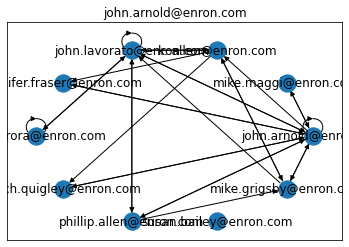

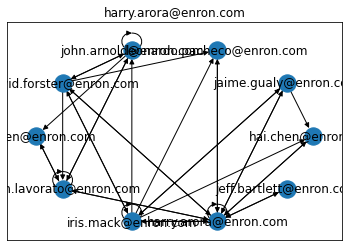

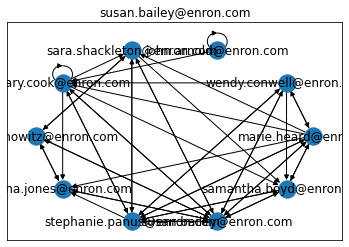

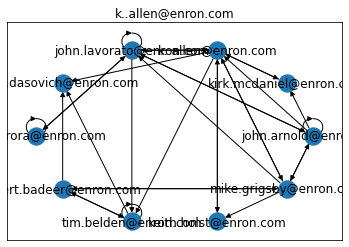

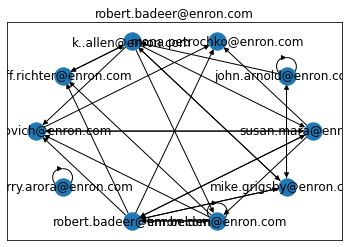

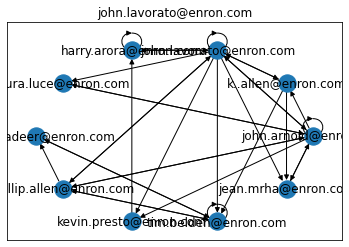

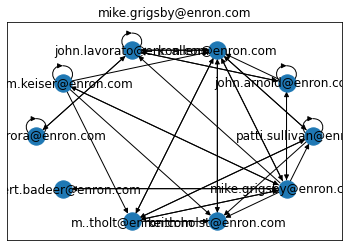

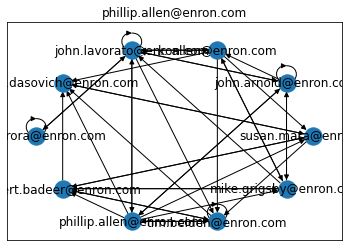

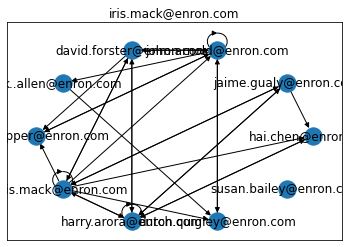

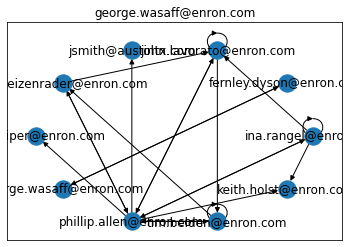

In [ ]:
#personalized page rank plots for top page ranked people

#choose how many people we want to look at here, plot circle layout for each 
how_many = 10
names = [x[0] for x in (sorted(pr(G).items(), key = lambda x: x[1], reverse = True))[0:how_many]]

for name in names:
    node_list = [x[0] for x in (sorted(ppr(G, name).items(), key = lambda x: x[1], reverse = True))[0:how_many]]
    H = nx.subgraph(G, [x[0] for x in (sorted(ppr(G, name).items(), key = lambda x: x[1], reverse = True))[0:how_many]])
    nx.draw_networkx(H, pos=nx.circular_layout(H), arrows = True, nodelist = node_list, with_labels=True)
    plt.title(name)
    plt.show()
    
#I observe that many top figures at Enron are in each others circles and appear repeatedly in my analysis. more on this later

In [ ]:
## Kmeans clustering with page rank 

#number of clusters we want to separate the data into. I tested a bunch of numbers and landed on this number through visual analysis of the outputs
k = 6

#number of iterstions of the kmeans algorithm
iters = 100

#calculate shortest path from each node to all others, store this in a dictionary
all_dists = dict(nx.all_pairs_shortest_path_length(G))

#take k random nodes from graph G
k_random_nodes = sample(list(G.nodes()), k)

#initialize our centroids to be these randomly selected nodes
current_centers = k_random_nodes 

#initialize our output dictionary. this will be a dict of nodes with their corresponding centroid 
output_dict = {}


#K Means clustering: 

#loop through max number of iterations times
for i in range(0,iters):
    
        #for each node in G, access the shortest path dictionary for that node.   
        for node in G.nodes():
            
            #get dict for just this node 
            all_dists_this_node = all_dists[node]
            
            #initialize temp dictionary to store distance to each of the center candidates for this current node
            dist_this_node_centers = {}
            
            #for each center in the current list of centers that we're considering, find its distance from the node we're considering
            for c in current_centers:
                    
                    #check that the center is in the all distances dictionary. if it's not then there's no edge between the two 
                    if c in all_dists_this_node:
                        dist_this_node_centers[c] = all_dists_this_node[c]
                        
                    #if not connnected to current node, will not be in the pairwise distance dictionary, set to infinity so it's ignored when we take the min
                    else:
                        dist_this_node_centers[c] = np.inf
                        
            #take the minimum distance from this node to the centroid candidates, key is dict values here          
            mincenter = min(dist_this_node_centers, key = dist_this_node_centers.get)
            
            #store the min dist to a centroid from this node in the ouput dictionary
            output_dict[node] = mincenter
        
        #now, we have to update the centers with each iteration
        
        #initialize empty array to store the new centers in 
        centers_new = [] 
        
        #loop thru each of our current centers
        for center in current_centers:
            
            #our dictionary is key (email): center . want list of keys that has the value center
            subgraph_nodes = [ i for i in output_dict if output_dict[i] == center ]
            
            #create a subgraph of G that has only the nodes closest to that center
            subgraph = G.subgraph(subgraph_nodes)
            
            #find center of the subgraph using the centrality metric of page rank.  
            #the highest ranked one becomes the new center 
            page_rank = nx.pagerank(subgraph, weight = 'weight')
            centers_new.append(max(page_rank, key = page_rank.get))
        
        
        #check if new centers are the same as the old ones. if they are then stop the loop
        if sorted(centers_new)== sorted(current_centers):
            break
        
        #if not terminated, update old centers to be the new ones
        current_centers = centers_new
        
        #if we've gone thru all iters without converging, end and print that we fail
        if i == iters:
            print('Max iter no converegence!')
            
            

In [ ]:
#let's try to visualize these clusters that we just found

#vector colors that we will draw from for each cluster
colors = ['red', 'yellow', 'green', 'blue', 'pink', 'purple', 'brown']
node_size = 30

#these are our centers that the algorithm returned, should be k of them.
vals = np.unique(list(output_dict.values()))

#color dictionary, give all nodes in same cluster the same color
color_dic = {}
i = 0

for v in vals:
    color_dic[v]  = colors[i]
    i += 1
    
color_map = []

for node in G.nodes():
    v = output_dict[node]
    color_map.append(color_dic[v])
        

In [ ]:
#visualize this with different clusters here

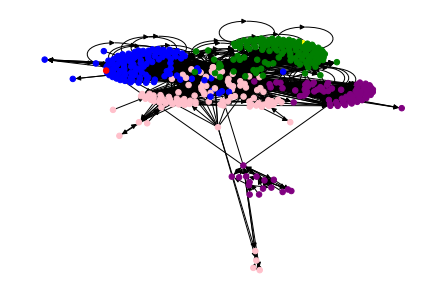

In [ ]:
nx.draw(G, pos = nx.fruchterman_reingold_layout(G), node_size = node_size, node_color = color_map)

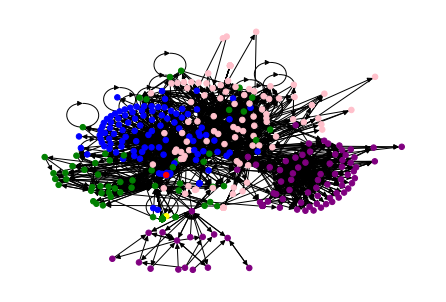

In [ ]:
nx.draw(G, pos = nx.kamada_kawai_layout(G), node_size = node_size, node_color = color_map)

In [ ]:
#let's see who the centroid cluster people are:

In [ ]:
vals

array(['customerservice@qwikfliks.com', 'garrett.tripp@enron.com',
       'harry.arora@enron.com', 'john.arnold@enron.com',
       'k..allen@enron.com', 'susan.bailey@enron.com'], dtype='<U29')

{'customerservice@qwikfliks.com': Text(-0.14646968440349076, -0.0973239845964259, 'customerservice@qwikfliks.com'),
 'garrett.tripp@enron.com': Text(-0.1462173319231628, -0.41236204464223225, 'garrett.tripp@enron.com'),
 'harry.arora@enron.com': Text(-0.19442218851448745, -0.17997565206952348, 'harry.arora@enron.com'),
 'john.arnold@enron.com': Text(-0.1486579240790065, 0.17109566085256334, 'john.arnold@enron.com'),
 'k..allen@enron.com': Text(0.05751079705239865, 0.3537258462272153, 'k..allen@enron.com'),
 'susan.bailey@enron.com': Text(0.39753517127318655, -0.08426386638579611, 'susan.bailey@enron.com')}

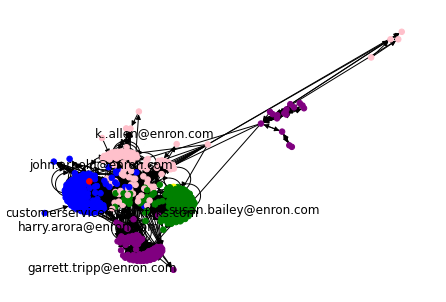

In [ ]:
#let's try plotting again and only labeling the centroid people, curious to see whose in the middle of which clusters here 
labels = {}    
for node in G.nodes():
    if node in vals:
        labels[node] = node

nx.draw(G, with_labels = False, node_size = 30, node_color = color_map)

nx.draw_networkx_labels(G, nx.kamada_kawai_layout(G), labels,  font_size = 12)

['phillip.allen@enron.com', 'john.arnold@enron.com', 'k..allen@enron.com', 'harry.arora@enron.com', 'robert.badeer@enron.com', 'jeff.dasovich@enron.com', 'john.lavorato@enron.com', 'mike.grigsby@enron.com', 'tim.belden@enron.com', 'susan.mara@enron.com']


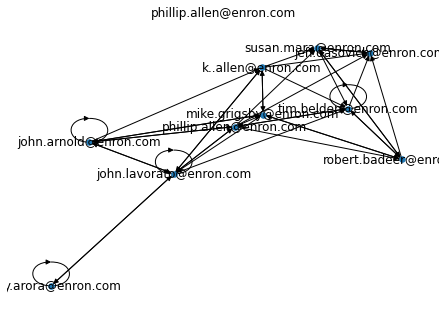

In [ ]:
#Phillip Allen, Managing Director Trading
name = 'phillip.allen@enron.com'

node_list = [x[0] for x in (sorted(ppr(G, name).items(), key = lambda x: x[1], reverse = True))[0:how_many]]
print(node_list)
H = nx.subgraph(G, [x[0] for x in (sorted(ppr(G, name).items(), key = lambda x: x[1], reverse = True))[0:how_many]])
nx.draw(H, pos = nx.kamada_kawai_layout(G), node_size = 30,with_labels = True)
#nx.draw_networkx(H, pos=nx.circular_layout(H), arrows = True, nodelist = node_list, with_labels=True)
plt.title(name)
plt.show()


{'phillip.allen@enron.com': Text(0.02491792950213765, 0.20914660455456216, 'phillip.allen@enron.com')}

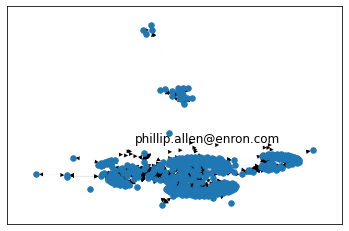

In [ ]:
#personalized page rank, Philip Allen
alpha_vec = list(map(lambda x: x*2, list(ppr(G, 'phillip.allen@enron.com').values())))
nx.draw_networkx(G,node_size=30, width = alpha_vec, with_labels = False)

labels = {}
labels['phillip.allen@enron.com'] = 'phillip.allen@enron.com'
nx.draw_networkx_labels(G, nx.kamada_kawai_layout(G), labels,  font_size = 12)

{'george.wasaff@enron.com': Text(-0.30901711398948956, -0.9510564600362343, 'george.wasaff@enron.com'),
 'harry.arora@enron.com': Text(-0.8090169917999684, 0.5877852551873061, 'harry.arora@enron.com'),
 'iris.mack@enron.com': Text(-0.30901702458252295, 0.9510564894417184, 'iris.mack@enron.com'),
 'john.arnold@enron.com': Text(1.0, 1.4702742047251475e-08, 'john.arnold@enron.com'),
 'john.lavorato@enron.com': Text(0.30901697689880736, 0.9510565490463628, 'john.lavorato@enron.com'),
 'k..allen@enron.com': Text(0.8090170037208972, 0.5877852551873061, 'k..allen@enron.com'),
 'mike.grigsby@enron.com': Text(0.8090169441162529, -0.5877852853864663, 'mike.grigsby@enron.com'),
 'phillip.allen@enron.com': Text(-0.809016932195324, -0.5877852853864663, 'phillip.allen@enron.com'),
 'robert.badeer@enron.com': Text(-0.999999988079071, -7.272003400514403e-08, 'robert.badeer@enron.com'),
 'susan.bailey@enron.com': Text(0.3090171259104184, -0.9510564600362343, 'susan.bailey@enron.com')}

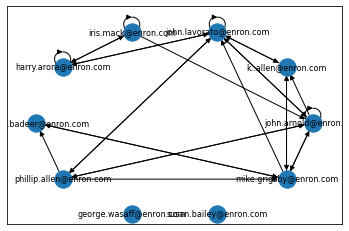

In [ ]:
#here I create plots where the thickness of an edge corresponds to the number of emails that were sent between the two nodes
#this was not very illuminating with the entire graph since there are so many nodes

#specify how many and create subgraph as above
how_many = 10
node_list = [x[0] for x in (sorted(pr(G).items(), key = lambda x: x[1], reverse = True))[0:how_many]]

H1 = nx.subgraph(G, [x[0] for x in (sorted(pr(G).items(), key = lambda x: x[1], reverse = True))[0:how_many]])


for u, v, d in H1.edges(data=True):
    d['wgt'] = H1.number_of_edges(u=u, v=v) 
edges,weights_vec = zip(*nx.get_edge_attributes(H1,'wgt').items())


pos = nx.circular_layout(H1)
#pos = nx.kamada_kawai_layout(H1)

#I played around with the API here to see how I could most clearly visualize the edge weights.
#nx.draw_networkx_edge_labels(H1, pos)
nx.draw_networkx_nodes(H1, pos, nodelist=H1.nodes(), node_size=300)
nx.draw_networkx_edges(H1, pos, edgelist=H1.edges(), alpha=1, edge_color='k', width=weights_vec, style = 'solid')
nx.draw_networkx_labels(H1, pos, font_size=8)

{'george.wasaff@enron.com': Text(-0.30901711398948956, -0.9510564600362343, 'george.wasaff@enron.com'),
 'harry.arora@enron.com': Text(-0.8090169917999684, 0.5877852551873061, 'harry.arora@enron.com'),
 'iris.mack@enron.com': Text(-0.30901702458252295, 0.9510564894417184, 'iris.mack@enron.com'),
 'john.arnold@enron.com': Text(1.0, 1.4702742047251475e-08, 'john.arnold@enron.com'),
 'john.lavorato@enron.com': Text(0.30901697689880736, 0.9510565490463628, 'john.lavorato@enron.com'),
 'k..allen@enron.com': Text(0.8090170037208972, 0.5877852551873061, 'k..allen@enron.com'),
 'mike.grigsby@enron.com': Text(0.8090169441162529, -0.5877852853864663, 'mike.grigsby@enron.com'),
 'phillip.allen@enron.com': Text(-0.809016932195324, -0.5877852853864663, 'phillip.allen@enron.com'),
 'robert.badeer@enron.com': Text(-0.999999988079071, -7.272003400514403e-08, 'robert.badeer@enron.com'),
 'susan.bailey@enron.com': Text(0.3090171259104184, -0.9510564600362343, 'susan.bailey@enron.com')}

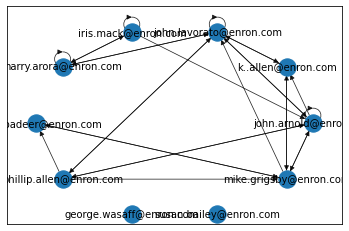

In [ ]:
how_many = 10
node_list = [x[0] for x in (sorted(pr(G).items(), key = lambda x: x[1], reverse = True))[0:how_many]]


H1 = nx.subgraph(G, [x[0] for x in (sorted(pr(G).items(), key = lambda x: x[1], reverse = True))[0:how_many]])


minLineWidth = 0.25

for u, v, d in H1.edges(data=True):
    d['weight'] = H1.number_of_edges(u=u, v=v) * 0.75
edges,weights = zip(*nx.get_edge_attributes(H1,'weight').items())


pos = nx.circular_layout(H1)

#nx.draw_networkx_edge_labels(H1, pos)
nx.draw_networkx_nodes(H1, pos,
                       nodelist=H1.nodes(),
                       node_size=300)
nx.draw_networkx_edges(H1, pos,
                       edgelist=H1.edges(),
                       alpha=0.85, edge_color='k', width=weights, style = 'solid')
nx.draw_networkx_labels(H1, pos, font_size=10, font_color='black')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


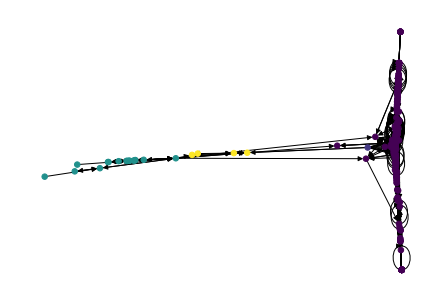

In [ ]:
#here I create a spectral graph based on the method used in lecture 19 

#create adjacency matric, diagonal degree matrix, graph laplacian

A2 = (nx.adjacency_matrix(G).todense())
D2_vec = (A2.sum(axis=1)).reshape(-1)
D2_vec = np.array(D2_vec)[0]
D2 = np.diag(D2_vec)
L2 = D2 - A2
L2 = np.array(L2)

#get evals and evecs, sort 
S2, U2 = np.linalg.eig(L2)
idsort = np.argsort(S2)
x = U2[:,idsort[1]]

#plot this graphh
plt.figure()
nx.draw_spectral(G, node_color = x, node_size = 30)

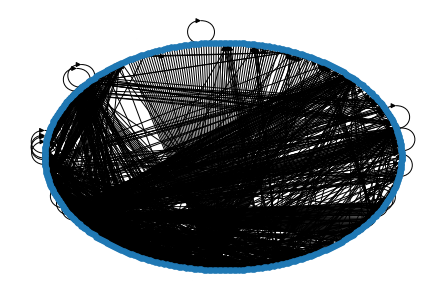

In [ ]:
#plot of all nodes and edges. This layout is not really helpful but it shows us that there is a ton of data in the dataset 
#you can see from this that there are some darker and lighter shaded regions on the graph indicating areas where individuals might have a higher pagerank on average possibly 

nx.draw_shell(G, node_size = 30)

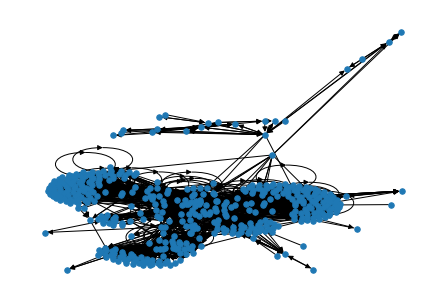

In [ ]:
#we can see a cluster on the right here 
nx.draw_spring(G, node_size = 30)


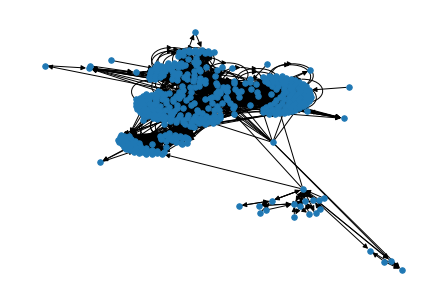

In [ ]:
#again we can see the cluster on the left, from the other angle
nx.draw(G, node_size = 30)

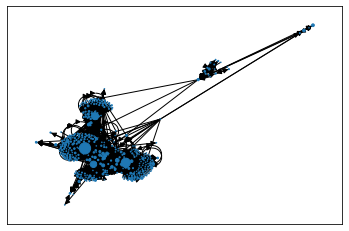

In [ ]:
#graph where node size corresponds to page rank 

nx.draw_networkx(G,node_size=[1000*v for v in pr(G).values()], with_labels = False)

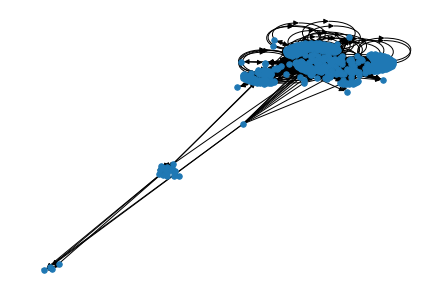

In [ ]:
#spring layout 

nx.draw(G, nx.spring_layout(G, iterations = 100), node_size = 30)

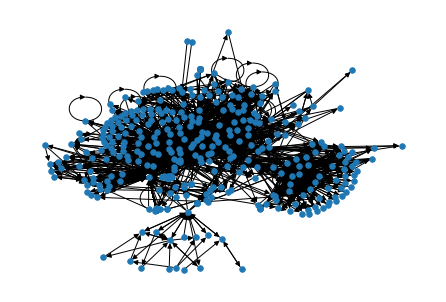

In [ ]:
#kamada kawai layout

nx.draw(G, pos = nx.kamada_kawai_layout(G), node_size = 30)

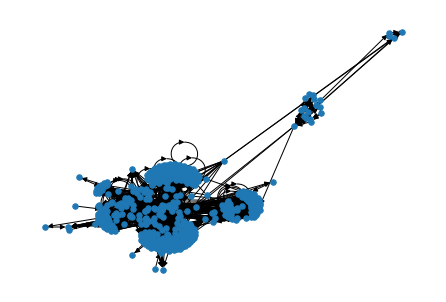

In [ ]:
#fruchterman reingold layout

nx.draw(G, pos = nx.fruchterman_reingold_layout(G), node_size = 30)

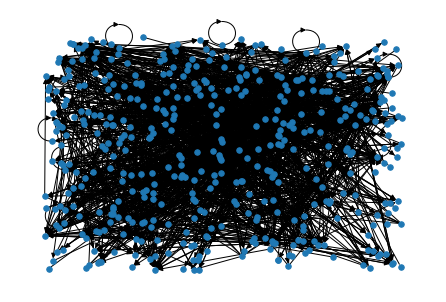

In [ ]:
#random layout 
#shows density of graph but not very useful otherwise
nx.draw(G, pos = nx.random_layout(G), node_size = 30)

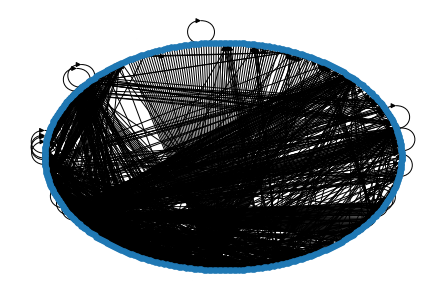

In [ ]:
#shell layout 
#similar to first circle plot
nx.draw(G, pos = nx.shell_layout(G), node_size = 30)

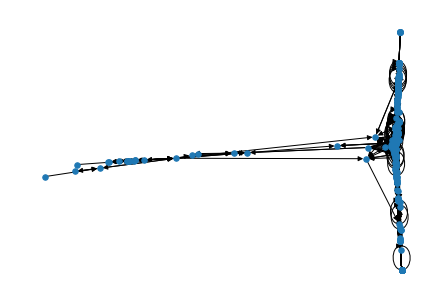

In [ ]:
#spectral layout 
#earlier from side view it seems
nx.draw(G, pos = nx.spectral_layout(G), node_size = 30)

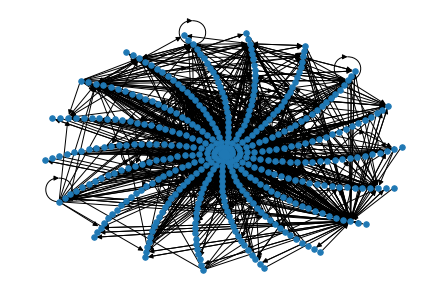

In [ ]:
#spiral layout
#cool but not very useful
nx.draw(G, pos = nx.spiral_layout(G), node_size = 30)

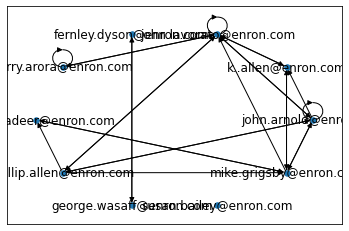

In [ ]:
#top int(how_many) nodes by page rank

how_many = 10
node_list = [x[0] for x in (sorted(pr(G).items(), key = lambda x: x[1], reverse = True))[0:how_many]]


H = nx.subgraph(G, [x[0] for x in (sorted(pr(G).items(), key = lambda x: x[1], reverse = True))[0:how_many]])
nx.draw_networkx(H, pos = nx.circular_layout(H), nodelist = node_list, with_labels = True, node_size = 30)